In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pandas as pd
import csv
from IPython.display import display
import json
import random

In [2]:
train_ratio = 0.9
with open('dataset.json', 'r') as ufile:
    data = json.load(ufile)

random.shuffle(data)
train_size = int(len(data)*train_ratio)

train_data = data[:train_size]
test_data = data[train_size:]

## Preparing the dictionaries

We need to convert words to numbers, so we first create a dictionary.

In [3]:
SOS_token = 0
EOS_token = 1

# words in a dictionary 
class Lang:
    def __init__(self, use_chars = False, min_count = 0):
        self.min_count = min_count
        self.use_chars = use_chars
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNC"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        """if use_chars, each character is a key"""
        words = sentence.split(' ') if not self.use_chars else sentence
        for word in words:
            self.addWord(word)

    def addWord(self, word):
        if word not in ['', '.', 's']:
            if word not in self.word2index:
                self.word2index[word] = self.n_words
                self.word2count[word] = 1
                self.index2word[self.n_words] = word
                self.n_words += 1
            else:
                self.word2count[word] += 1
        
    def removeUncommon(self):
        uncommon = 0
        uncommon_keys = []
        for word in self.word2count:
            if self.word2count[word] < self.min_count and self.word2index[word] > 2:
                uncommon_keys.append(word)
        for word in uncommon_keys:
            uncommon += self.word2count[word]
            self.word2count.pop(word)
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNC"}
        self.word2index = {"UNC": 2}
        self.n_words = 3  # Count SOS and EOS
        for word in self.word2count:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1
        self.word2count["UNC"] = uncommon
        
    def tensorFromSentence(self, sentence, remove_unc = False):
        words = sentence.split(' ') if not self.use_chars else sentence
        if self.min_count:
            if remove_unc:
                words = [w for w in words if w in self.word2index.keys()]
            else:
                words = [w if w in self.word2index.keys() else "UNC" for w in words]
        indexes = [self.word2index[word] for word in words]
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [4]:
import unicodedata
import re

# Minimum number of appearances of a word. Otherwise it is discarded.
min_count = 100

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
import random

lang = Lang(min_count=2)
print("Counting words...")
for file in train_data:
    for sentence in file['words']:
        lang.addSentence(normalizeString(sentence))
lang.removeUncommon()
print("Counted words:")
print(lang.n_words)

print('')
print('Some random entries:')
print(random.choices([i for i in lang.word2count], k=10))

print('')
print('Most popular words in nav contents:')
for i in sorted([(i, lang.word2count[i]) for i in lang.word2count if lang.word2count[i] >1500], key=lambda x:x[1]):
    print(i[0], i[1])

Counting words...
Counted words:
9756

Some random entries:
['proceed', 'tradition', 'ideaboards', 'levers', 'abandonment', 'charles', 'disease', 'eyeliner', 'ga', 'firelord']

Most popular words in nav contents:
your 1591
the 1767
for 1890
a 2302
and 3262
to 4362
UNC 4773


In [6]:
output_lang = Lang(min_count=2)
print("Counting words...")
for file in train_data:
    output_lang.addSentence(normalizeString(file['label']))
output_lang.removeUncommon()
print("Counted words:")
print(output_lang.n_words)

print('')
print('Some random entries:')
print(random.choices([i for i in output_lang.word2count], k=10))

print('')
print('Most popular words in labels:')
for i in sorted([(i, output_lang.word2count[i]) for i in output_lang.word2count if output_lang.word2count[i] >60], key=lambda x:x[1]):
    print(i[0], i[1])

Counting words...
Counted words:
372

Some random entries:
['kith', 'items', 'university', 'iras', 'wide', 'opinion', 'popular', 'c', 'corporate', 'alphabetical']

Most popular words in labels:
global 62
and 67
top 72
social 72
utility 74
posts 87
mobile 126
site 158
secondary 192
links 194
footer 240
primary 255
UNC 339
main 648
menu 717
navigation 1037


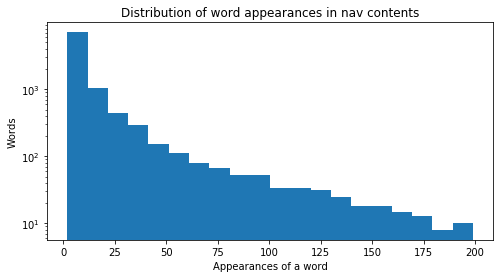

In [7]:
from matplotlib import pyplot as plt
import random

fig, ax = plt.subplots(figsize=(8,4))
vals = lang.word2count.values()
ax.hist([i for i in vals if i<200], bins=20)
ax.set_yscale('log')
ax.set_ylabel('Words')
ax.set_xlabel('Appearances of a word')
ax.set_title('Distribution of word appearances in nav contents')
plt.show()

We need something similar for the letters of the input

## Actually making the models

In [8]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Training

In [11]:
teacher_forcing_ratio = 0.5

def train_step(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [12]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    if percent > 0:
        es = s / (percent)
    else:
        es = 0
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [22]:
def prepare_words(sentences, max_words = 20):
    nav_words = []
    for sentence in sentences:
        for word in sentence.split(' '):
            nav_words.append(word)
    nav_words = ' '.join(nav_words[:max_words])
    return normalizeString(nav_words)

def nav_to_tensor(nav, lang):
    
    lcodes = {'body': 0, 'header': 1, 'footer': 2}
    nav_location = nav['location']
    nav_location_code = lcodes[nav_location] if (nav_location in lcodes) else 3
                          
    input_tensor = lang.tensorFromSentence(prepare_words(nav['words']))
    other_inputs = torch.tensor([[nav_location_code], [nav['index']]])
    return torch.cat((other_inputs, input_tensor))

class NavDataGenerator:
    def __init__(self, navs, input_lang, output_lang):
        self.navs = navs
        self.input_lang = input_lang
        self.output_lang = output_lang
    def get_case(self, i=None):
        nav = random.choice(self.navs) if (i is None) else self.navs[i]
        input_tensor = nav_to_tensor(nav, self.input_lang)
        target_tensor = output_lang.tensorFromSentence(normalizeString(nav['label']), remove_unc=True)
        
        return input_tensor, target_tensor

nav_gen_train = NavDataGenerator(train_data, lang, output_lang)
nav_gen_test = NavDataGenerator(test_data, lang, output_lang)

prepare_words(train_data[2]['words'])

'personal insurance business insurance about liberty mutual about our company international careers'

In [14]:
def train(data_generator, encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, timeout = None, max_len=3):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    
    for iter in range(n_iters):
        input_tensor, target_tensor = data_generator.get_case()
        loss = train_step(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
        if timeout is not None:
            if (time.time() - start) > timeout:
                break

    showPlot(plot_losses)


In [15]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


In [16]:
def evaluate(encoder, decoder, nav, input_lang, output_lang, max_length=3):
    with torch.no_grad():
        input_tensor = nav_to_tensor(nav, input_lang)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token and len(decoded_words) > 0:
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words


In [17]:
def evaluateRandomly(encoder, decoder, data, input_lang, output_lang, n=10):
    for i in range(n):
        nav = random.choice(data)
        print('INPUT     |', prepare_words(nav['words']))
        print('LABEL     |', nav['label'])
        output_words = evaluate(encoder, decoder, nav, input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('PREDICTED |', output_sentence)
        print('')


0m 0s (- -1m 59s) (0 0%) 0.0297
0m 29s (- 4m 27s) (200 10%) 3.9920
0m 59s (- 3m 57s) (400 20%) 3.8435
1m 29s (- 3m 28s) (600 30%) 4.2729
1m 59s (- 2m 59s) (800 40%) 4.7303
2m 29s (- 2m 29s) (1000 50%) 5.4378
3m 0s (- 2m 0s) (1200 60%) 4.6302
3m 30s (- 1m 30s) (1400 70%) 4.3706
4m 0s (- 1m 0s) (1600 80%) 4.7262
4m 29s (- 0m 29s) (1800 90%) 5.5180


<Figure size 432x288 with 0 Axes>

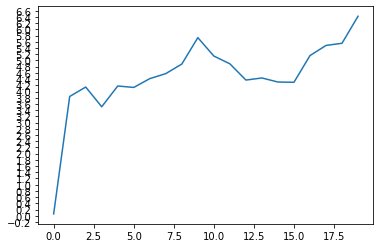

In [18]:

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(nav_gen_train, encoder, decoder, 2000, print_every=200)


In [19]:
evaluateRandomly(encoder, decoder, test_data, lang, output_lang)

INPUT     | weather climate chevron everything you need to know about the forecast and making the most of the weather . find
LABEL     | second level
PREDICTED | main navigation

INPUT     | admissions academics campus life athletics research about uwf search sticky header search bar
LABEL     | Sticky header main navigation
PREDICTED | main navigation

INPUT     | about us press media careers terms of service privacy policy blog
LABEL     | Footer menu 2
PREDICTED | site

INPUT     | contact choose your country . current selection is the global website . global australia brasil deutschland france sweden
LABEL     | utility
PREDICTED | primary navigation

INPUT     | posts navigation next posts 
LABEL     | Posts
PREDICTED | posts posts

INPUT     | dewalt logo
LABEL     | Primary Navigtion
PREDICTED | main menu

INPUT     | 
LABEL     | Clubs Menu
PREDICTED | main menu

INPUT     | common tasks view pay bill manage my
LABEL     | Footer
PREDICTED | site

INPUT     | about the berklee 